In [41]:
from langchain.document_loaders import DirectoryLoader, PyPDFLoader
from langchain.vectorstores import Pinecone
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone as PC
from pinecone import ServerlessSpec
from langchain_text_splitters import RecursiveCharacterTextSplitter
import os
import glob
from sentence_transformers import SentenceTransformer
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.document_loaders import FileSystemBlobLoader
from langchain.document_loaders.generic import GenericLoader
from langchain.document_loaders.parsers import PyPDFParser
import time
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import uuid
from openai import OpenAI #Deprecated because i can't use his API(needs money)
from ollama import Client
from more_itertools import chunked  # ou use uma função caseira

In [42]:
#gerar n versoes da pergunta
#criar novos docs a partir do artigo, categorizados

In [43]:
loader = DirectoryLoader(
    "./rag-projeto/data",
    glob="*.pdf",
    loader_cls=PyPDFLoader
)

In [44]:
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # Tamanho máximo de cada pedaço
    chunk_overlap=50 # Sobreposição entre pedaços
)
docs_splitted = text_splitter.split_documents(docs)

texts = [doc.page_content for doc in docs_splitted]
#criar ID para rastrear os vetores
ids = [str(uuid.uuid4()) for _ in range(len(texts))]
#Apaga todos os vetores mas mantem o index criado
#index.delete(delete_all=True)

In [45]:

os.environ['PINECONE_API_KEY'] = 'pcsk_6JsENF_EkUKdhWBGJXSsKsbKdU2E5HAuGGq8AvfAvaCjFYj2BJUBxgEPq9GHQYMk2wK6ST'


In [46]:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
embeddings = model.encode(texts, show_porgress_bar=True)

In [47]:
index_name = "rag"
pc = PC(api_key="pcsk_6JsENF_EkUKdhWBGJXSsKsbKdU2E5HAuGGq8AvfAvaCjFYj2BJUBxgEPq9GHQYMk2wK6ST")
index = pc.Index(index_name)

In [57]:
# Suponha que cada vetor tenha cerca de 20KB, então 100 vetores ~ 2MB
def batch_upsert(index, vectors, batch_size=100):
    for i in range(0, len(vectors), batch_size):
        batch = vectors[i:i + batch_size]
        index.upsert(vectors=batch)




In [51]:
embedder = HuggingFaceEmbeddings(
    model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2", cache_folder="./ModeltoEmbedding"
)
#texts eh uma lista de strings onde cada string é um documento.Essa função gera os embeddings
embeddings= embedder.embed_documents(texts)
# Associar os embeddings com seus IDs
vectors = [(ids[i] ,embeddings[i]) for i in range(len(embeddings))]
# Inserir os embeddings no Pinecone (upsert)
# index.upsert(vectors=vectors)

# Exemplo de uso
batch_upsert(index, vectors)

# vectorstore = PineconeVectorStore.from_documents(docs_splitted, embedder, index_name=index_name)
index.describe_index_stats()


{'dimension': 384,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 32411}},
 'total_vector_count': 32411,
 'vector_type': 'dense'}

In [52]:
query = "O que é bom comer para evitar diabetes?"


#Funçao do pinecone que já realiza a busca
# similar_docs = vectorstore.similarity_search(query, k=5)
#função para pegar o embedding do query
query_embedding = embedder.embed_query(query)

In [53]:

#Resultado do metodo de busca padrao.
# similar_docs
print(index)


In [54]:
#Implementando uma busca personalizada
#Baseando-se na busca de similaridade por cosseno , para mais detalhes: https://pt.wikipedia.org/wiki/Produto_escalar
#Tem esse estudo falando sobre o problema deste método que é interessante: https://www.shaped.ai/blog/cosine-similarity-not-the-silver-bullet-we-thought-it-was
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# Calcular similaridade entre a consulta e todos os documentos
similarities = [cosine_similarity(query_embedding,doc_embedding) for doc_embedding in embeddings]
# Ordenar os índices dos documentos pela similaridade de forma decrescente
sorted_indices = np.argsort(similarities)[::-1]

# Obter os documentos mais semelhantes (top 5)
top_k = 100
top_docs = [texts[i] for i in sorted_indices[:top_k]]
top_similarities = [similarities[i] for i in sorted_indices[:top_k]]
top_embeddings = [embeddings[i] for i in sorted_indices[:top_k]]
# Exibir os resultados
for doc, sim in zip(top_docs, top_similarities):
    print(f"Similaridade: {sim:.4f}")
    print(f"Documento: {doc[:1000]}...")  # Exibir os primeiros 200 caracteres do documento
    print("-" * 50)


Similaridade: 0.6887
Documento: Terapia Nutricional no Diabetes tipo 1
Diretriz da Sociedade Brasileira de Diabetes | 2
alimentosin natura, ricos em nutrientes e em porções adequadas, para melhorar a saúde
geral, contribuir para os estágios do desenvolvimento e crescimento, além de alcançar e
manter as metas de peso corporal, obter metas adequadas de glicemia, pressão e lipídios
sanguíneos, de forma individualizada, além de retardar ou prevenir as complicações do
diabetes....
--------------------------------------------------
Similaridade: 0.6755
Documento: Natália Victor Elias, Larissa Silva Barbosa  | Benefícios da dieta com baixo índice glicêmico no controle da glicemia e perda 
ponderal de pacientes com Diabetes Mellitus tipo 2: Revisão sistemática de ensaios clínicos randomizados 
 
 
 
R. Assoc. bras. Nutr. 2021; 12 (4): 186-200 
ISSN 2357-7894 
 
 
197 
alimentos sobre a glicemia. Não há dúvidas, portanto, que o consenso gira em torno 
de uma intervenção nutricional adequada e i

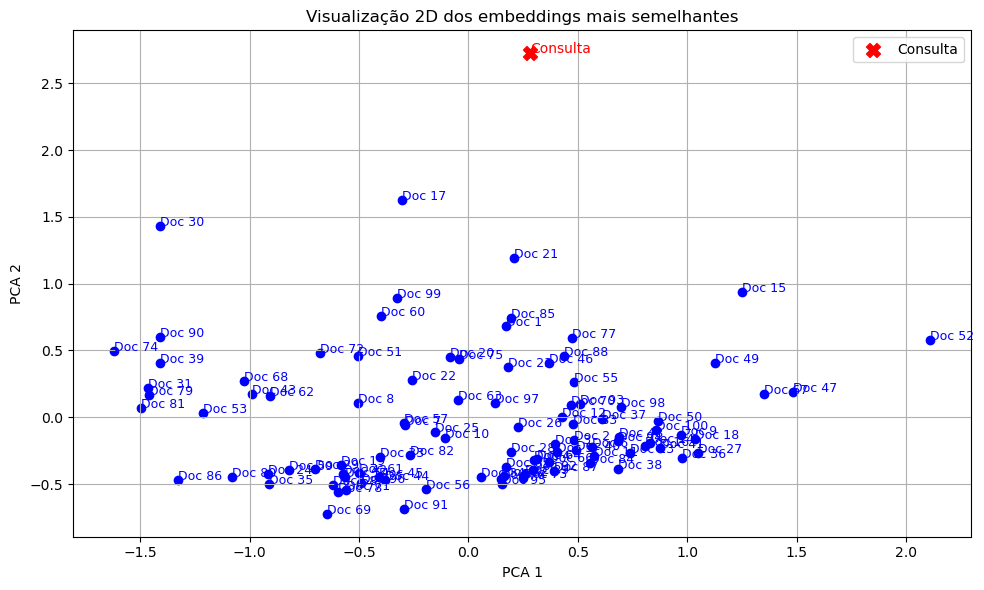

In [55]:
# Plotar os vetores em 2D com PCA
pca = PCA(n_components=2)
points_2d = pca.fit_transform(np.array(top_embeddings + [query_embedding]))

plt.figure(figsize=(10, 6))

# Plotar documentos
for i in range(top_k):
    plt.scatter(*points_2d[i], color='blue')
    plt.text(points_2d[i][0], points_2d[i][1], f'Doc {i+1}', color='blue', fontsize=9)

# Plotar consulta
plt.scatter(*points_2d[-1], color='red', marker='X', s=100, label='Consulta')
plt.text(points_2d[-1][0], points_2d[-1][1], 'Consulta', color='red', fontsize=10)

plt.title("Visualização 2D dos embeddings mais semelhantes")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [56]:
#Chamar a IA com o prompt + contexto do RAG
prompt_final = "Dados para consulta: " + texts[sorted_indices[0]] + "\nResponda sobre: " + query

print(prompt_final)
client = Client()
response = client.chat(
    model='mistral',
    messages=[
       
        {"role": "user", "content": prompt_final},
        
    ]
)

print(response['message']['content'])

Dados para consulta: Terapia Nutricional no Diabetes tipo 1
Diretriz da Sociedade Brasileira de Diabetes | 2
alimentosin natura, ricos em nutrientes e em porções adequadas, para melhorar a saúde
geral, contribuir para os estágios do desenvolvimento e crescimento, além de alcançar e
manter as metas de peso corporal, obter metas adequadas de glicemia, pressão e lipídios
sanguíneos, de forma individualizada, além de retardar ou prevenir as complicações do
diabetes.
Responda sobre: O que é bom comer para evitar diabetes?
 Para minimizar o risco de desenvolver diabetes tipo 1 e melhorar a gestão da doença em casos existentes, é recomendado um estilo de vida saudável que inclui uma dieta equilibrada. Essa dieta é rica em alimentos naturais, baixos em gorduras saturadas e carboidratos simples, e altos em nutrientes essenciais como fibra, vitaminas e minerais. Alguns exemplos de alimentos saudáveis para incluir na dieta são:

1. Frutas e vegetais:  abundantes em fibra, vitaminas e minerais. Co